In [1]:
# install split-folders agar mempermudah membagi kategori kebeberapa file
!pip install split-folders

In [2]:
# import library yang dibutuhkan
import tensorflow as tf
import zipfile,os
import splitfolders
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
from keras.preprocessing import image
%matplotlib inline

In [3]:
# memastikan bahwa versi TensorFlow yang digunakan adalah versi 2 ke atas
print(tf.__version__)

2.5.0


In [4]:
# mengunduh dataset
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2021-07-25 03:09:11--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  3.57MB/s    in 94s     

2021-07-25 03:10:46 (3.28 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [5]:
# melakukan ekstraksi pada file zip
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
 
base_dir = '/tmp/rockpaperscissors/rps-cv-images'
train_dir = '/content/output/train'
validation_dir = '/content/output/val'

In [6]:
# memisahkan folder dataset menjadi train 60% dan val 40%
splitfolders.ratio(base_dir, output="output", seed=1337, ratio=(.6, .4), group_prefix=None)

Copying files: 2188 files [00:00, 2823.08 files/s]


In [7]:
# melihat struktur data pada folder train
os.listdir('/content/output/train')

['scissors', 'rock', 'paper']

In [8]:
# melihat struktur data pada folder validation
os.listdir('/content/output/val')

['scissors', 'rock', 'paper']

In [9]:
# membuat direktori sesuai dengan direktori data training
train_rock_dir = os.path.join(train_dir, 'rock')
train_paper_dir = os.path.join(train_dir, 'paper')
train_scissors_dir = os.path.join(train_dir, 'scissors')

# membuat direktori sesuai dengan direktori data validation
val_rock_dir = os.path.join(validation_dir, 'rock')
val_paper_dir = os.path.join(validation_dir, 'paper')
val_scissors_dir = os.path.join(validation_dir, 'scissors')

In [10]:
# augmentasi gambar yang dilakukan dengan objek ImageDataGenerator
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [11]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')
 
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


In [12]:
# membangun model CNN untuk klasifikasi gambar
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [13]:
# memanggil fungsi compile pada objek model dan menentukan loss function serta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [14]:
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.97):
      print("Training dihentikan karena akurasi sudah mencapai 0.97")
      self.model.stop_training = True

callbacks = Callback()

In [15]:
# melatih model dengan menggunakan metode fit
model_status = model.fit(
      train_generator,
      steps_per_epoch=25,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=5,
      verbose=2,
      callbacks=[callbacks])

Epoch 1/20
25/25 - 45s - loss: 1.0871 - accuracy: 0.4075 - val_loss: 1.0436 - val_accuracy: 0.4750
Epoch 2/20
25/25 - 43s - loss: 0.7776 - accuracy: 0.6625 - val_loss: 0.4878 - val_accuracy: 0.8000
Epoch 3/20
25/25 - 43s - loss: 0.3396 - accuracy: 0.8788 - val_loss: 0.3355 - val_accuracy: 0.8625
Epoch 4/20
25/25 - 44s - loss: 0.2731 - accuracy: 0.9075 - val_loss: 0.3027 - val_accuracy: 0.8938
Epoch 5/20
25/25 - 43s - loss: 0.2355 - accuracy: 0.9100 - val_loss: 0.2590 - val_accuracy: 0.9312
Epoch 6/20
25/25 - 43s - loss: 0.1750 - accuracy: 0.9438 - val_loss: 0.3494 - val_accuracy: 0.8813
Epoch 7/20
25/25 - 43s - loss: 0.1941 - accuracy: 0.9300 - val_loss: 0.2579 - val_accuracy: 0.9250
Epoch 8/20
25/25 - 43s - loss: 0.1391 - accuracy: 0.9588 - val_loss: 0.1054 - val_accuracy: 0.9625
Epoch 9/20
25/25 - 43s - loss: 0.1268 - accuracy: 0.9600 - val_loss: 0.1040 - val_accuracy: 0.9688
Epoch 10/20
25/25 - 43s - loss: 0.0832 - accuracy: 0.9688 - val_loss: 0.1323 - val_accuracy: 0.9500
Epoch 11/

In [16]:
# evaluasi model untuk accuracy dan loss
eval_train = model.evaluate(train_generator)
print("Test Accuracy: %.2f%%" % (eval_train[1]*100))
eval_validation = model.evaluate(validation_generator)
print("Test Validation: %.2f%%" % (eval_validation[1]*100))

41/41 [==============================] - 24s 579ms/step - loss: 0.0894 - accuracy: 0.9726
Test Accuracy: 97.26%
28/28 [==============================] - 16s 563ms/step - loss: 0.1133 - accuracy: 0.9680
Test Validation: 96.80%


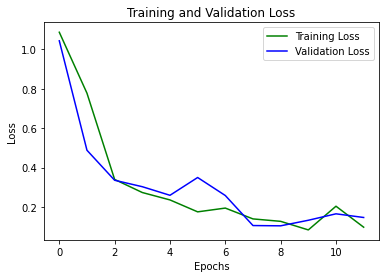

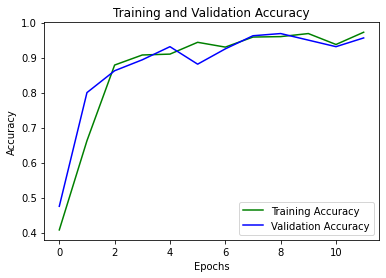

In [17]:
# visualisasi accuracy dan loss
visual_acc = model_status.history['accuracy']
vissual_loss = model_status.history['loss']
vissual_val_acc = model_status.history['val_accuracy']
vissual_val_loss = model_status.history['val_loss']

plt.plot(vissual_loss, 'g', label='Training Loss')
plt.plot(vissual_val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(visual_acc, 'g', label='Training Accuracy')
plt.plot(vissual_val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Saving 14K62H4KG1hg5qi.jpeg to 14K62H4KG1hg5qi (1).jpeg
14K62H4KG1hg5qi.jpeg
Paper


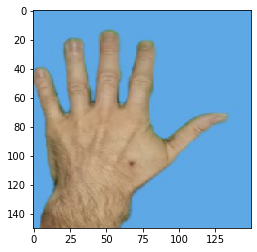

In [21]:
# menguji kelayakan model yang telah dibangun dengan mempridiksi gambar yang diunggah
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # prediksi images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  if classes[0,0]==1.0:
    print('Paper')
  elif classes[0,1]==1.0:
    print('Rock')
  else:
    print('Scissors')

In [ ]:
Nama: Fia Amara Sandra Hardiana
Email Dicoding: fiaamara13@gmail.com